In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# finalize model and make a prediction for monthly births with random forest
from numpy import asarray
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import concat
from sklearn.ensemble import RandomForestRegressor
import joblib

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [ ]:
# data_path = "/content/drive/MyDrive/Colab Notebooks/Hitachi/Data/final_data.csv"
data_path = "final_price_data.csv"
data_df = pd.read_csv(data_path)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34896 entries, 0 to 34895
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Delivery Day      34896 non-null  object 
 1   Hours             34896 non-null  object 
 2   Prices
(EUR/MWh)  34896 non-null  float64
 3   datetime          34896 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.1+ MB


In [ ]:
data_df.head()

,Delivery Day,Hours,Prices\n(EUR/MWh),datetime
0,1/1/2020,H1,26.38,2020-01-01 01:00:00
1,1/1/2020,H2,26.50,2020-01-01 02:00:00
2,1/1/2020,H3,27.01,2020-01-01 03:00:00
3,1/1/2020,H4,27.40,2020-01-01 04:00:00
4,1/1/2020,H5,27.99,2020-01-01 05:00:00


In [ ]:
data_df['datetime'] = pd.to_datetime(data_df['datetime'])  # Convert the column to datetime format if it's not already

data_df_sorted = data_df.sort_values(by='datetime')

# If you want to sort in descending order, use the following:
# df_sorted = df.sort_values(by='datetime_column', ascending=False)

# Resetting the index after sorting
data_df_sorted = data_df_sorted.reset_index(drop=True)

In [ ]:
data_df_sorted.head()

,Delivery Day,Hours,Prices\n(EUR/MWh),datetime
0,1/1/2020,H24,34.00,2020-01-01 00:00:00
1,1/1/2020,H1,26.38,2020-01-01 01:00:00
2,1/1/2020,H2,26.50,2020-01-01 02:00:00
3,1/1/2020,H3,27.01,2020-01-01 03:00:00
4,1/1/2020,H4,27.40,2020-01-01 04:00:00


In [ ]:
data_df_sorted.tail()

,Delivery Day,Hours,Prices\n(EUR/MWh),datetime
34891,12/24/2023,H19,79.99,2023-12-24 19:00:00
34892,12/24/2023,H20,71.09,2023-12-24 20:00:00
34893,12/24/2023,H21,62.01,2023-12-24 21:00:00
34894,12/24/2023,H22,53.41,2023-12-24 22:00:00
34895,12/24/2023,H23,50.10,2023-12-24 23:00:00


# Training of the Random Forest Model on WHOLE DATA

In [ ]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [ ]:
# load the dataset
series = data_df_sorted["Prices\n(EUR/MWh)"]
values = series.values
values.shape

(34896,)

In [ ]:
values = values.reshape((34896, 1))
values.shape

(34896, 1)

In [ ]:
# Use first 20% of dataset as the test dataset
# Use 80 % of data as train dataset
# 20% of total data (27552) = 5510
first_20_percent_index = int(0.2 * 34896)

train_values = values[first_20_percent_index:, :]
test_values = values[:first_20_percent_index, :]
train_values.shape, test_values.shape

((27917, 1), (6979, 1))

In [ ]:
# 3 weeks of data is used as prior data => 24 * 7 * 3 = 504
number_of_weeks = 3
previous_data_dependency_hours = 24*7*number_of_weeks
# transform the time series data into supervised learning
train_supervised_data = series_to_supervised(train_values, n_in=previous_data_dependency_hours)
test_supervised_data = series_to_supervised(test_values, n_in=previous_data_dependency_hours)

In [ ]:
train_supervised_data.shape

(27413, 505)

In [ ]:
# split into input and output columns
train_X, train_y = train_supervised_data[:, :-1], train_supervised_data[:, -1]
train_X.shape, train_y.shape

((27413, 504), (27413,))

In [ ]:
# fit model
n_estimators = 1000
model = RandomForestRegressor(n_estimators=n_estimators, verbose=1, n_jobs=-1)
model.fit(train_X, train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 18.1min finished


RandomForestRegressor(n_estimators=1000, n_jobs=-1, verbose=1)

In [ ]:
model_path = "MODEL ARCHIVE/univariate_price_rfr.pkl"
# model_path = "/content/drive/MyDrive/Colab Notebooks/Hitachi/MODEL ARCHIVE/univariate_price_rfr.pkl"

In [ ]:
save_model = True
if save_model:
  joblib.dump(model, model_path)

## Testing the model

In [ ]:
loaded_model = joblib.load(model_path)

In [ ]:
test_X, test_y = test_supervised_data[:, :-1], test_supervised_data[:, -1]

In [ ]:
test_prediction = loaded_model.predict(test_X)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.1s finished


In [ ]:
test_y.shape, test_prediction.shape

((6475,), (6475,))

The Mean Squared Error (MSE) is a common metric used to measure the average squared difference between the predicted values and the actual values in a regression problem.

MAPE expresses the prediction error as a percentage of the actual value. It is useful when you want to understand the relative error.

MAE measures the average absolute difference between the actual and predicted
values. It is in the same unit as the original data.

In [ ]:
# Mean squared Error and Mean Absolute Percentage Error (MAPE)
print(mean_squared_error(test_y, test_prediction))
print(mean_absolute_percentage_error(test_y, test_prediction))
print(mean_absolute_error(test_y, test_prediction))

37.14015834842283
22868492951404.95
3.9510432494208505


In [ ]:
def plot_truth_vs_pred(test_y, test_prediction, number_to_plot):
    pred_df = pd.DataFrame({'ground_truth' : test_y[:number_to_plot], 'prediction' : test_prediction[:number_to_plot]})
    sns.lineplot(data=pred_df)
    plt.title(f"Ground Truth vs Predicted Price {number_to_plot} datapoints")

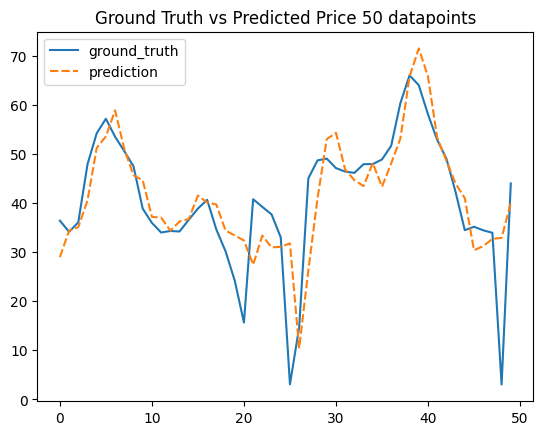

In [ ]:
plot_truth_vs_pred(test_y, test_prediction, number_to_plot=50)

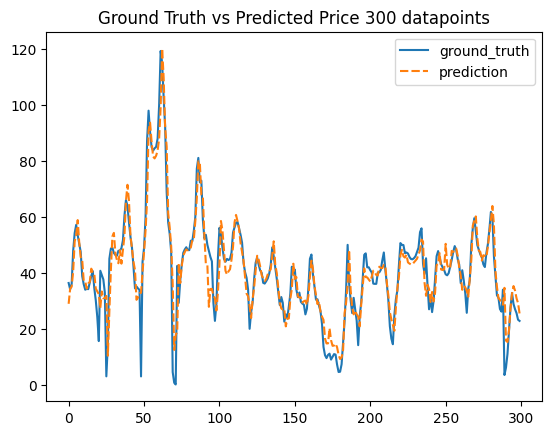

In [ ]:
plot_truth_vs_pred(test_y, test_prediction, number_to_plot=300)

## Submission Prediction

In [ ]:
def week_demand_prediction(last_3_week_data):
  week_demand = []
  count = 0
  last_3_week_data = last_3_week_data.reshape((1, 504))
  while count < 24*7:
    pred = loaded_model.predict(last_3_week_data)
    last_3_week_data = np.concatenate((last_3_week_data[:, 1:], pred.reshape(1, -1)), axis=1)
    count += 1
    week_demand.append(float(pred))

  return week_demand

In [ ]:
last_3_week_data = values[-previous_data_dependency_hours:]
week_price = week_demand_prediction(last_3_week_data)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.1s finished
/tmp/ipykernel_27439/3746954831.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  week_demand.append(float(pred))
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 task

In [ ]:
len(week_price), week_price[:2]

(168, [47.15327, 69.04457999999997])

In [ ]:
# plot the week demand prediction
last_3_week_data = values[-previous_data_dependency_hours:]
last_3_week_data = last_3_week_data.reshape((1, 504))
week_price_series = np.array(week_price)
last_3_week_data.shape, week_price_series.shape

((1, 504), (168,))

In [ ]:
past_values = list(last_3_week_data.ravel())
forecast_values = list(week_price_series)

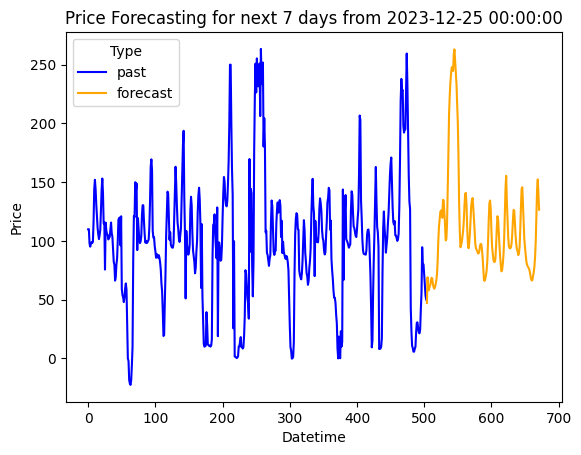

In [ ]:
# Create a list of colors for past and forecast values
colors = ['blue'] * len(past_values) + ['orange'] * len(forecast_values)
types = ['past'] * len(past_values) + ['forecast'] * len(forecast_values)

# Combine past and forecast values into a single array
combined_values = past_values + forecast_values

# Create a DataFrame for seaborn
import pandas as pd
df = pd.DataFrame({'Values': combined_values, 'Color': colors, 'Type' : types})

# Plot using seaborn
plot = sns.lineplot(data=df, x=df.index, y='Values', hue='Type', palette={'past': 'blue', 'forecast': 'orange'})
plt.ylabel("Price")
plt.xlabel("Datetime")
plt.title("Price Forecasting for next 7 days from 2023-12-25 00:00:00")
# Show the plot
plt.show()